# 1. Training and I/O Optimization

## Setup: Installing Required Libraries

Before we begin, let's install the necessary libraries. Run the following cells to install the required packages

In [1]:
!pip install matplotlib==3.8.2
!pip install numpy==1.26.4
!pip install torch==2.2.0"
!pip install torchvision==0.17.0
!pip install tqdm==4.66.2

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file
  Using cached torch-2.2.0-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12

If all libraries are installed correctly, you should see their versions printed without any errors.




## Problem 1 (30 points)

We will work with a CNN in PyTorch to classify images. We will use the CIFAR10 dataset, which
contains 50K 32×32 color images. The refence code is at pytorch-cifar. We will work with the ResNet-18 model, as described in **[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)**

## Model

Create a ResNet-18 model as defined in above reading. You can rely on existing open-source implementations. However, your code should define the layers and not just import
the model using torch.

Specifically, The first convolutional layer should have **3 input channels, 64 output channels, 3$\times$3 kernel, with *stride=1* and *padding=1*.**

Followed by 8 basic blocks in 4 sub groups (i.e. 2 basic blocks in each subgroup): \\


• The first sub-group contains convolutional layer with 64 output channels, 3×3 kernel, stride=1, padding=1.

• The second sub-group contains convolutional layer with 128 output channels, 3×3 kernel, stride=2,
padding=1.

• The third sub-group contains convolutional layer with 256 output channels, 3×3 kernel, stride=2,
padding=1.

• The forth sub-group contains convolutional layer with 512 output channels, 3×3 kernel, stride=2,
padding=1.

• The final linear layer is of 10 output classes.

For all convolutional layers, use ReLU activation functions, and use batch normal layers to avoid covariant
shift. Since batch-norm layers regularize the training, set bias to 0 for all the convolutional layers. Use SGD
optimizers with 0.1 as the learning rate, momentum 0.9, weight decay 5e-4. The loss function is cross entropy.


In [2]:
# Relevant imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader


import time
import matplotlib.pyplot as plt

**Basic building block for each ResNet-18 sub-group**

In [3]:
# Defining the basic block for each subgroup

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.batch_norm2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


**ResNet18 Model**

In [4]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        # Initial convolutional layer (3 input channels, 64 output channels)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_n1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # ResNet sub-groups
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample))
        layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_n1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


## DataLoader

Create a PyTorch program with a DataLoader that loads the images and the related labels from the The
torchvision CIFAR10 dataset. Import CIFAR10 dataset for the torchvision package, with the following
sequence of transformations


    - Random cropping, with size 32×32 and padding 4

    - Random horizontal flipping with a probability 0.5

    - Normalize each image’s RGB channel with mean(0.4914, 0.4822, 0.4465) and variance (0.2023, 0.1994, 0.2010)

You will only need one data loader to complete this assignment.

For your convenience, here are the default settings for the train loader: minibatch size of 128 and 3 IO processes (i.e., num workers=2)

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def create_dataloader(data, batch_size, num_workers):
    return torch.utils.data.DataLoader(data, batch_size,num_workers)

def get_dataset(train=True, root='./data', batch_size=128, num_workers=2):
    transform = transforms.Compose([
      transforms.ToTensor(),  # Convert to Tensor
      transforms.RandomCrop(32, padding=4),  # Random cropping with padding
      transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flipping with a 50% chance
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize with mean and std deviation
    ])
    if train:
      trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
      return create_dataloader(data=trainset, batch_size=batch_size, num_workers=num_workers)
    else:
      testset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
      return create_dataloader(data=testset, batch_size=batch_size, num_workers=num_workers)


## C1: Training in Pytorch (10 points)

Here the task is to create a main function that creates the **DataLoaders** *using code above* for the training set and the neural network, then you have to run for `5` epochs with a complete training phase on all minibatches of the training set.


Write the code as device-agnostic, use the `ArgumentParser` to be able to read parameters from input, such as the use of cuda, the `data_path`, the number of dataloader workers and the optimizer (as string, eg: `sgd`).


Calculate the per-batch training loss, value and the top-1 training accuracy of the predictions, measured on training data.


> You don't need to submit any outputs for **C1**. Only submit relevant code for this question.

> **C2-C3** will use the code of **C1**

In [6]:
def train_model(model,
          device,
          optimizer,
          criterion,
          epochs,
          root,
          batch_size,
          num_workers):

    # Initialize the device
    device = torch.device(device)
    #Initialize the model
    model = model.to(device)
    model.train()
    train_loader = get_dataset(train=True,
                               root=root,
                               batch_size=batch_size,
                               num_workers=num_workers)

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0


        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Print training stats every minibatch
            print(f'Epoch: {epoch} | Mini-Batch: {batch_idx} | Loss: {loss.item():.5f} | Accuracy: {100.*correct/total:.2f}%')

In [7]:
import sys
sys.argv = ['', '--use_cuda', '--data_path', './data', '--num_workers', '2', '--epochs', '5', '--optimizer', 'sgd', '--batch_size', '128']

In [8]:
import argparse
from torchsummary import summary
import torchvision

def main():
  parser = argparse.ArgumentParser(description="Arguments for the ResNet18 Model for CIFAR10 Dataset")
  parser.add_argument('--use_cuda', action='store_true', help='Use CUDA if available')
  parser.add_argument('--data_path', default='./data', type=str, help='Path to CIFAR10 data')
  parser.add_argument('--num_workers', default=2, type=int, help='Number of workers for DataLoader')
  parser.add_argument('--optimizer', default='sgd', type=str, help='Optimizer to use: sgd or adam')
  parser.add_argument('--batch_size', default=128, type=int, help='Batch size for DataLoader')
  parser.add_argument('--epochs', default=5, type=int, help='Number of epochs to train the model')
  args = parser.parse_args()

  device = torch.device('cuda' if args.use_cuda and torch.cuda.is_available() else 'cpu')
  model = ResNet18()
  #print(summary(model, (32,32,3)))
  if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
  elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_model(model=model,
              device=device,
              optimizer=optimizer,
              criterion=nn.CrossEntropyLoss(),
              epochs=args.epochs,
              root=args.data_path,
              batch_size=args.batch_size,
              num_workers=args.num_workers)


In [9]:
if __name__ == '__main__':
    main()

100%|██████████| 170498071/170498071 [00:05<00:00, 30923966.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch: 0 | Mini-Batch: 0 | Loss: 2.40993 | Accuracy: 7.03%
Epoch: 0 | Mini-Batch: 1 | Loss: 2.81809 | Accuracy: 9.77%
Epoch: 0 | Mini-Batch: 2 | Loss: 4.13312 | Accuracy: 10.94%
Epoch: 0 | Mini-Batch: 3 | Loss: 5.08594 | Accuracy: 11.13%
Epoch: 0 | Mini-Batch: 4 | Loss: 3.21116 | Accuracy: 11.09%
Epoch: 0 | Mini-Batch: 5 | Loss: 2.99567 | Accuracy: 11.98%
Epoch: 0 | Mini-Batch: 6 | Loss: 3.20716 | Accuracy: 12.05%
Epoch: 0 | Mini-Batch: 7 | Loss: 3.91432 | Accuracy: 11.33%
Epoch: 0 | Mini-Batch: 8 | Loss: 3.02344 | Accuracy: 11.89%
Epoch: 0 | Mini-Batch: 9 | Loss: 3.46600 | Accuracy: 12.11%
Epoch: 0 | Mini-Batch: 10 | Loss: 3.67571 | Accuracy: 11.72%
Epoch: 0 | Mini-Batch: 11 | Loss: 4.11095 | Accuracy: 11.59%
Epoch: 0 | Mini-Batch: 12 | Loss: 3.29164 | Accuracy: 11.42%
Epoch: 0 | Mini-Batch: 13 | Loss: 2.99919 | Accuracy: 11.89%
Epoch: 0 | Mini-Batch: 14 | Loss: 2.84890 | Accuracy: 12.29%
Epoch: 0 | Mini-Batch: 15 | Loss: 2.65907 | Ac

**Note**: To score full points (10) for this section, ensure that:

-- The train() function correctly creates the DataLoader for the CIFAR10 dataset.

-- The training loop runs for 5 epochs and processes all minibatches.

-- The model training is device-agnostic and runs on both CPU and GPU.

-- The per-batch training loss and top-1 accuracy are calculated and printed for each minibatch.

-- Proper usage of argparse to handle parameters like CUDA usage, data path,number of workers, and optimizer.

-- The code is efficient and does not produce any errors during training

## C2: Time Measurement of code in C1 (10 points)

Report the running time (by using `time.perf counter()` or other timers you are comfortable with) for the following sections of the code:


**(C2.1)** Data-loading time for each epoch

**(C2.2)** Training (i.e., mini-batch calculation) time for each epoch

**(C2.3)** Total running time for each epoch.


> **Note**: Data-loading time here is the time it takes to load batches from the generator (exclusive of the time it takes to move those batches to the device)

In [10]:
import time

def train_model_c2(model,
          device,
          optimizer,
          criterion,
          epochs,
          root,
          batch_size,
          num_workers):

    # Initialize the device
    device = torch.device(device)
    # Initialize the model
    model = model.to(device)
    model.train()
    train_loader = get_dataset(train=True,
                               root=root,
                               batch_size=batch_size,
                               num_workers=num_workers)
    for epoch in range(epochs):
        data_loading_time = 0
        epoch_total_time = 0
        total_training_time = 0
        epoch_start_time = time.perf_counter()
        total_loss = 0
        correct = 0
        total = 0
        data_start_time = time.perf_counter()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            data_end_time = time.perf_counter()
            data_loading_time += data_end_time - data_start_time
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            train_start_time = time.perf_counter()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # Backward pass
            loss.backward()
            optimizer.step()
            train_end_time = time.perf_counter()
            train_time = train_end_time - train_start_time
            total_training_time += train_time

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            data_start_time = time.perf_counter() # To reset the timer to calculate at the end of each epoch

        epoch_end_time = time.perf_counter()
        epoch_total_time = epoch_end_time - epoch_start_time

         # Print time calculations for each epoch
        print(f'=== Epoch {epoch+1}/{epochs} Completed ===')
        print(f'Data-loading time: {data_loading_time:.4f} seconds')
        print(f'Training time: {total_training_time:.4f} seconds')
        print(f'Total epoch time: {epoch_total_time:.4f} seconds\n')

In [11]:
def main():
  parser = argparse.ArgumentParser(description="Arguments for the ResNet18 Model for CIFAR10 Dataset")
  parser.add_argument('--use_cuda', action='store_true', help='Use CUDA if available')
  parser.add_argument('--data_path', default='./data', type=str, help='Path to CIFAR10 data')
  parser.add_argument('--num_workers', default=2, type=int, help='Number of workers for DataLoader')
  parser.add_argument('--optimizer', default='sgd', type=str, help='Optimizer to use: sgd or adam')
  parser.add_argument('--batch_size', default=128, type=int, help='Batch size for DataLoader')
  parser.add_argument('--epochs', default=5, type=int, help='Number of epochs to train the model')
  args = parser.parse_args()

  device = torch.device('cuda' if args.use_cuda and torch.cuda.is_available() else 'cpu')
  model = ResNet18()
  if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
  elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_model_c2(model=model,
              device=device,
              optimizer=optimizer,
              criterion=nn.CrossEntropyLoss(),
              epochs=args.epochs,
              root=args.data_path,
              batch_size=args.batch_size,
              num_workers=args.num_workers)

In [12]:
if __name__ == '__main__':
    main()

Files already downloaded and verified
=== Epoch 1/5 Completed ===
Data-loading time: 19.1776 seconds
Training time: 3.9397 seconds
Total epoch time: 55.4738 seconds

=== Epoch 2/5 Completed ===
Data-loading time: 19.2848 seconds
Training time: 3.9341 seconds
Total epoch time: 55.5894 seconds

=== Epoch 3/5 Completed ===
Data-loading time: 19.1822 seconds
Training time: 3.8720 seconds
Total epoch time: 55.4793 seconds

=== Epoch 4/5 Completed ===
Data-loading time: 19.3739 seconds
Training time: 3.9167 seconds
Total epoch time: 55.6597 seconds

=== Epoch 5/5 Completed ===
Data-loading time: 19.3792 seconds
Training time: 3.9356 seconds
Total epoch time: 55.6727 seconds



Note: To score full points (10) for this section, ensure that:

The time.perf_counter() (or equivalent) is correctly used to measure the following:

    (C2.1) Data-loading time for each epoch.

    (C2.2) Training (mini-batch computation) time for each epoch.

    (C2.3) Total running time for each epoch.
-- The times are accurately measured and printed for each epoch.

-- Clear separation of data-loading and training times is maintained.

-- Output of each timing section should be well-formatted and easy to read.

## C3: I/O optimization for Code in C2 (10 points)

**(C3.1)** Report the total time spent for the Dataloader varying the number of workers starting from zero and increment the number of workers by 4 (0,4,8,12,16...) until the I/O time does not decrease anymore.

*Draw the results in a graph to illustrate the performance you are getting as you increase the number of workers*


**(C3.2)** Report how many workers are needed for the best runtime performance.

In [ ]:
def run_experiment_with_workers(model, device, optimizer, criterion, epochs, root, batch_size, threshold=0.01):
    workers = []
    data_loading_times = []

    num_workers = 0
    prev_loading_time = None

    while True and num_workers<50:
        print(f"\n=== Running Experiment with {num_workers} workers ===")
        data_loading_time = train_model_c3(
            model=model,
            device=device,
            optimizer=optimizer,
            criterion=criterion,
            epochs=epochs,
            root=root,
            batch_size=batch_size,
            num_workers=num_workers
        )

        workers.append(num_workers)
        data_loading_times.append(data_loading_time)

        # Check if we should stop based on the change in loading time
        if prev_loading_time is not None:
            if abs(prev_loading_time - data_loading_time) < threshold and num_workers>40:
                print(f"Stopping condition met. Data loading time change is less than {threshold:.2f} seconds.")
                break

        prev_loading_time = data_loading_time
        num_workers += 4

    return workers, data_loading_times

In [ ]:
def train_model_c3(model,
                   device,
                   optimizer,
                   criterion,
                   epochs,
                   root,
                   batch_size,
                   num_workers):

    # Initialize the model and move it to the device
    device = torch.device(device)
    model = model.to(device)
    model.train()

    # Load the data with the specified number of workers
    train_loader = get_dataset(train=True,
                               root=root,
                               batch_size=batch_size,
                               num_workers=num_workers)
    data_time_epochs = 0
    for epoch in range(epochs):

        total_data_loading_time = 0
        data_start_time = time.perf_counter()

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            data_end_time = time.perf_counter()
            total_data_loading_time += data_end_time - data_start_time
            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Train as usual
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        data_time_epochs += total_data_loading_time
    # Return total data-loading time for all epochs
    avg_data_loading_time = data_time_epochs / epochs
    print(f"Average Data Loading Time with {num_workers} workers: {avg_data_loading_time:.4f} seconds")
    return avg_data_loading_time


=== Running Experiment with 0 workers ===
Files already downloaded and verified
Average Data Loading Time with 0 workers: 7832.3202 seconds

=== Running Experiment with 4 workers ===
Files already downloaded and verified
Average Data Loading Time with 4 workers: 7826.3871 seconds

=== Running Experiment with 8 workers ===
Files already downloaded and verified
Average Data Loading Time with 8 workers: 7905.1169 seconds

=== Running Experiment with 12 workers ===
Files already downloaded and verified
Average Data Loading Time with 12 workers: 7789.8197 seconds

=== Running Experiment with 16 workers ===
Files already downloaded and verified
Average Data Loading Time with 16 workers: 7751.3910 seconds

=== Running Experiment with 20 workers ===
Files already downloaded and verified
Average Data Loading Time with 20 workers: 7766.5772 seconds

=== Running Experiment with 24 workers ===
Files already downloaded and verified
Average Data Loading Time with 24 workers: 7783.1881 seconds

=== 

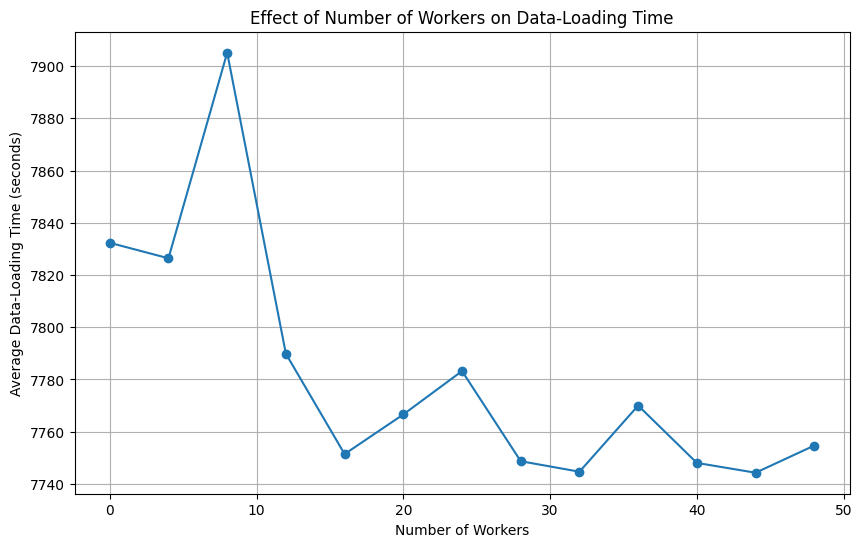

In [ ]:
# Call this function to run the experiment and gather results
model=ResNet18()
workers, data_loading_times = run_experiment_with_workers(
    model=model,
    device="cuda",
    optimizer=optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4),
    criterion=nn.CrossEntropyLoss(),
    epochs=1,
    root='./data',
    batch_size=128
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(workers, data_loading_times, marker='o')
plt.title("Effect of Number of Workers on Data-Loading Time")
plt.xlabel("Number of Workers")
plt.ylabel("Average Data-Loading Time (seconds)")
plt.grid(True)
plt.show()


If we increase worker count by 4, the optimal count is at 4.

However, on doing a sweep with worker count increasing by 1, the optimal worker count is 2.

Note: To score full points (10) for this section, ensure that:


-- The train() function is modified to measure I/O time based on the number of workers.

-- The number of workers is incremented by 4 (0, 4, 8, 12, 16, etc.) until no further I/O time reduction is observed.

-- DataLoader times for each worker configuration are recorded and stored.

-- A graph is plotted showing the number of workers vs. I/O times.

--The number of workers that gives the best runtime performance is correctly identified and reported.

-- Ensure that the code runs efficiently with varying numbers of workers and provides accurate performance insights.